In [206]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [207]:
import torchvision.transforms as transforms

class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        if phase not in self.data_transform:
            raise ValueError("phase must be 'train' or 'val'")
        return self.data_transform[phase](img)


In [208]:
import os
import cv2

cat_directory=r'/Users/chelsey/Desktop/project/euron/8th-DL/wk5/dogs-vs-cats/Cat'
dog_directory=r'/Users/chelsey/Desktop/project/euron/8th-DL/wk5/dogs-vs-cats/Dog'

cat_images_filepaths=sorted([os.path.join(cat_directory,f) for f in
                             os.listdir(cat_directory)])
dog_images_filepaths=sorted([os.path.join(dog_directory,f)for f in
                             os.listdir(dog_directory)])
cat_images_filepaths=[*cat_images_filepaths,*dog_images_filepaths]
correct_images_filepaths=[i for i in dog_images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths=correct_images_filepaths[:400]
val_images_filepaths=correct_images_filepaths[400:-10]
test_images_filepaths=correct_images_filepaths[-10:]
print(len(train_images_filepaths),len(val_images_filepaths), len (test_images_filepaths))

251 0 10


In [209]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

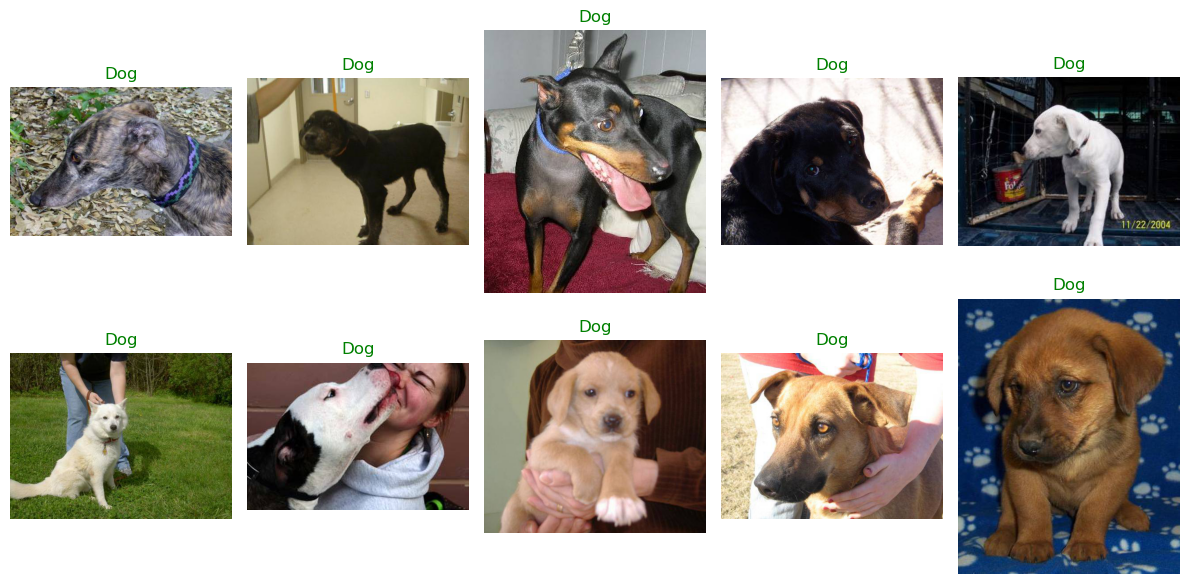

In [210]:
display_image_grid(test_images_filepaths)

In [211]:
class DogvsCatDataset(Dataset):
    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img_path=self.file_list[idx]
        img=Image.open(img_path)
        img_transformed=self.transform(img, self.phase)
        label=img_path.split('/')[-1].split('.')[0]
        if label=='dog':
            label=1
        elif label=='cat':
            label=0
        return img_transformed, label

In [212]:
size=224
mean=(0.485,0.456,0.406)
std=(0.229,0.224,0.225)
batch_size=32

In [213]:
train_dataset=DogvsCatDataset(train_images_filepaths,transform=ImageTransform(size,mean,std),phase='train')
val_dataset=DogvsCatDataset(val_images_filepaths,transform=ImageTransform(size,mean,std),phase='val')

index=0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


In [214]:
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
dataLoader_dict={'train':train_dataloader,'val':val_dataloader}

batch_iterator=iter(train_dataloader)
inputs,label=next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [215]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1,
                                  padding=0)
        self.relu1=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        self.cnn2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,
                                    stride=1, padding=0)
        self.relu2=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=2)
                
        self.fc1=nn.Linear(32*53*53,512)
        self.relu5=nn.ReLU()
        self.fc2=nn.Linear(512,2)
        self.output=nn.Softmax(dim=1)
                
    def forward(self,x):
            out=self.cnn1(x)
            out=self.relu1(out)
            out=self.maxpool1(out)
            out=self.cnn2(out)
            out=self.relu2(out)
            out=self.maxpool(out)
            out=out.view(out.size(0),-1)
            out=self.fc1(out)
            out=self.fc2(out)
            out=self.output(out)
            return out
            

In [216]:
model=LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [217]:
import torch
from torchsummary import summary
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [218]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [219]:
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
criterion=nn.CrossEntropyLoss()

In [220]:
model=model.to(device)
criterion=criterion.to(device)

In [221]:
def train_model(model,dataLoader_dict,criterion,optimizer,num_epoch):
    since=time.time()
    best_acc=0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1,num_epoch))
        print('-'*20)
        
        for phase in ['train','val']:
            if phase=='train':
                model.train()
            else:
                model.eval()
            epoch_loss=0.0
            epoch_corrects=0
            
            for inputs,labels in tqdm(dataLoader_dict[phase]):
                inputs=inputs.to(device)
                labels=labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs)
                    _, preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects+=torch.sum(preds==labels.data)
                
                epoch_loss=epoch_loss/len(dataLoader_dict[phase].dataset)
                epoch_acc = epoch_corrects.float() / len(dataLoader_dict[phase].dataset)
                
                print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase,epoch_loss,epoch_acc))
                
                if phase=='val' and epoch_acc > best_acc:
                    best_acc=epoch_acc
                    best_model_wts=model.state_dict()
                    
            time_elapsed=time.time()-since
            print('Traing complete in{:.0f}m {:.0f}s'.format(
                time_elapsed//60, time_elapsed%60))
            print('Best val Acc: {:4f}'.format(best_acc))
            return model

In [222]:
import time

num_epoch=10
model=train_model(model,dataLoader_dict,criterion,optimizer,num_epoch)

Epoch 1/10
--------------------


/var/folders/7p/npc42ml14hsdz2qfn43lc51m0000gn/T/ipykernel_47059/775446910.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs,labels in tqdm(dataLoader_dict[phase]):


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.0859 Acc:0.1235
train Loss: 0.0800 Acc:0.2510
train Loss: 0.0708 Acc:0.3785
train Loss: 0.0603 Acc:0.5060
train Loss: 0.0516 Acc:0.6335
train Loss: 0.0463 Acc:0.7610
train Loss: 0.0444 Acc:0.8884
train Loss: 0.0354 Acc:0.9960
Traing complete in0m 1s
Best val Acc: 0.000000


In [223]:
import pandas as pd

id_list=[]
pred_list=[]
_id=0

with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img=Image.open(test_path)
        _id=test_path.split('/')[-1].split('.')[1]
        transform=ImageTransform(size,mean,std)
        img=transform(img,phase='val')
        img=img.unsqueeze(0)
        img=img.to(device)
        
        model.eval()
        outputs=model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        
res=pd.DataFrame({
    'id':id_list,
    'label':pred_list
})
res.sort_values(by='id',inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/Users/chelsey/Desktop/project/euron/8th-DL/wk5/result.csv',index=False)

/var/folders/7p/npc42ml14hsdz2qfn43lc51m0000gn/T/ipykernel_47059/374294008.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [224]:
class_=classes={0:'cat',1:'dog'}
def display_image_grid(images_filepaths,predicted_labels=(),cols=5):
    rows=len(images_filepaths)//cols
    figure,ax=plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))
    for i, images_filepath in enumerate(images_filepaths):
        image=cv2.imread(images_filepath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        a=random.choice(res['id'].values)
        label=res.loc[res['id']==a,'label'].values[0]
        if label>0.5:
            label=1
        else:
            label=0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

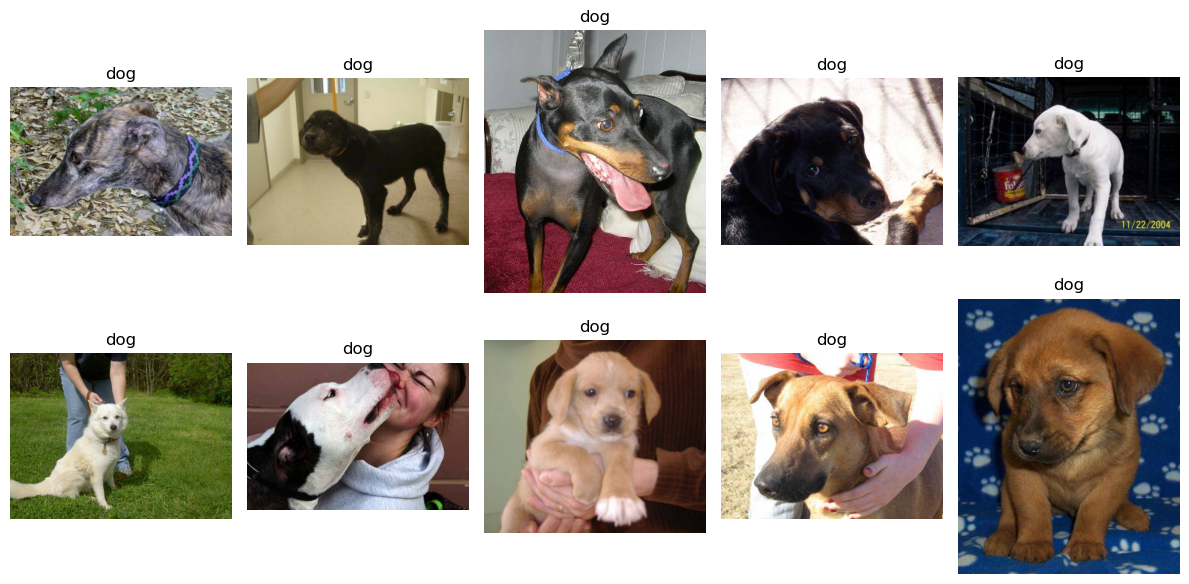

In [225]:
display_image_grid(test_images_filepaths)

In [226]:
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [227]:
from typing import Any


class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform={
            'train':transforms.Compose([
                transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            'val':transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [228]:
cat_directory='/Users/chelsey/Desktop/project/euron/8th-DL/wk5/dogs-vs-cats/Cat'
dog_directory='/Users/chelsey/Desktop/project/euron/8th-DL/wk5/dogs-vs-cats/Dog'

cat_images_filepaths=sorted([os.path.join(cat_directory,f)for f in os.listdir(cat_directory)])
dog_images_filepaths=sorted([os.path.join(dog_directory)for f in os.listdir(dog_directory)])

images_filepaths=[*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths=[i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths=correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths=correct_images_filepaths[-10:]
print(len(train_images_filepaths),len(val_images_filepaths),len(test_images_filepaths))

251 0 10


In [229]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list=file_list
        self.transform=transform
        self.phase=phase
        
    def __len__(self):
            return len(self.file_list)
        
    def __getitem__(self, idx):
            img_path=self.file_list[idx]
            img=Image.open(img_path)
            img_transformed=self.transform(img,self.phase)
            
            label=img_path.split('/')[-1].split('.')[0]
            if label=='dog':
                label=1
            elif label=='cat':
                label=0
                
            return img_transformed, label

In [230]:
size=256
mean=(0.485,0.456,0.406)
std=(0.229,0.224,0.225)
batch_size=32

In [231]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index=0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [232]:
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator=iter(train_dataloader)
inputs,label=next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [233]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [234]:
model=AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [235]:
optimizer=optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss()

In [236]:
from torchsummary import summary
model = model.to('cpu')
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [237]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            dataset_size = len(dataloader_dict[phase].dataset)
            if dataset_size == 0:
                print("Warning: {} dataset is empty.".format(phase))
                continue  # 또는 epoch_loss와 epoch_acc에 기본 값을 할당
            epoch_loss = epoch_loss / dataset_size
            epoch_acc = epoch_corrects.double() / dataset_size
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
   
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [238]:
import torch

device = torch.device('cpu')  # CPU 사용

model = model.to(device)

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


/var/folders/7p/npc42ml14hsdz2qfn43lc51m0000gn/T/ipykernel_47059/121137665.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.6913 Acc: 0.5936


0it [00:00, ?it/s]

Epoch 2/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.6613 Acc: 1.0000


0it [00:00, ?it/s]

Epoch 3/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.6164 Acc: 1.0000


0it [00:00, ?it/s]

Epoch 4/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.5643 Acc: 1.0000


0it [00:00, ?it/s]

Epoch 5/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.4999 Acc: 1.0000


0it [00:00, ?it/s]

Epoch 6/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.4066 Acc: 1.0000


0it [00:00, ?it/s]

Epoch 7/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.2428 Acc: 1.0000


0it [00:00, ?it/s]

Epoch 8/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.0607 Acc: 1.0000


0it [00:00, ?it/s]

Epoch 9/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.0060 Acc: 1.0000


0it [00:00, ?it/s]

Epoch 10/10
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

train Loss: 0.0010 Acc: 1.0000


0it [00:00, ?it/s]

Training complete in 0m 42s


In [239]:
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('../chap06/data/alexnet.csv', index=False)

/var/folders/7p/npc42ml14hsdz2qfn43lc51m0000gn/T/ipykernel_47059/397637477.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

OSError: Cannot save file into a non-existent directory: '../chap06/data'